# 1.0 Analyzing Neighborhood Safety by Crime Report Records

## Metric: Crime incidents per square mile by neighborhood

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import warnings
from datetime import datetime, timedelta
warnings.filterwarnings('ignore')

## 1.1 Load datasets

In [28]:
# set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("\n1. Loading datasets...")

# Load crime data from WPRDC
# This is a large dataset, so we'll read it with minimal parsing
crime_url = "https://data.wprdc.org/datastore/dump/e03a89dd-134a-4ee8-a2bd-62c40aeebc6f"
crime_df = pd.read_csv(crime_url)
print(f"loaded {len(crime_df):,} crime records")

neighborhoods_df = pd.read_csv("data/neighborhoods.csv")
print(f"loaded {len(neighborhoods_df):,} neighborhoods")


1. Loading datasets...
loaded 66,485 crime records
loaded 90 neighborhoods


## 1.2 Explore the data

In [29]:
print("\n2. Exploring data structure...")
print("\nCrime dataset columns:")
print(crime_df.columns.tolist())

print("\nNeighborhood dataset columns:")
print(neighborhoods_df.columns.tolist())

print("\nSample crime records:")
print(crime_df[['ARRESTTIME', 'INCIDENTNEIGHBORHOOD', 'OFFENSES', 'INCIDENTLOCATION']].head(10))

print("\nCrime type distribution (top 20):")
print(crime_df['OFFENSES'].value_counts().head(20))


2. Exploring data structure...

Crime dataset columns:
['_id', 'PK', 'CCR', 'AGE', 'GENDER', 'RACE', 'ARRESTTIME', 'ARRESTLOCATION', 'OFFENSES', 'INCIDENTLOCATION', 'INCIDENTNEIGHBORHOOD', 'INCIDENTZONE', 'INCIDENTTRACT', 'COUNCIL_DISTRICT', 'PUBLIC_WORKS_DIVISION', 'X', 'Y']

Neighborhood dataset columns:
['_id', 'objectid', 'fid_blockg', 'statefp10', 'countyfp10', 'tractce10', 'blkgrpce10', 'geoid10', 'namelsad10', 'mtfcc10', 'funcstat10', 'aland10', 'awater10', 'intptlat10', 'intptlon10', 'shape_leng', 'fid_neighb', 'pghdb_sde_neighborhood_2010_area', 'perimeter', 'neighbor', 'neighbor_i', 'hood', 'hood_no', 'acres', 'sqmiles', 'dpwdiv', 'unique_id', 'sectors', 'shape_le_1', 'shape_ar_1', 'page_number', 'plannerassign', 'globalid', 'created_user', 'created_date', 'last_edited_user', 'last_edited_date', 'temp', 'shape_area', 'shape_length']

Sample crime records:
            ARRESTTIME INCIDENTNEIGHBORHOOD  \
0  2016-08-24T12:20:00           Bloomfield   
1  2016-08-03T14:55:00     

## 1.3 Clean the data

In [30]:
# clean data
print("\n3. Cleaning data...")

# Parse date column
crime_df['ARRESTTIME'] = pd.to_datetime(crime_df['ARRESTTIME'], errors='coerce')

# Filter to last 5 years
cutoff_date = datetime.now() - timedelta(days=365*5)
crime_df = crime_df[crime_df['ARRESTTIME'] >= cutoff_date]
print(f"filtered to last 5 years: {len(crime_df):,} records remaining")

# Remove records with missing neighborhood
crime_df = crime_df.dropna(subset=["INCIDENTNEIGHBORHOOD"])
print(f"removed records without neighborhood: {len(crime_df):,} records remaining")

# Standardize neighborhood names
crime_df['INCIDENTNEIGHBORHOOD'] = crime_df['INCIDENTNEIGHBORHOOD'].str.strip().str.title()
neighborhoods_df['hood'] = neighborhoods_df['hood'].str.strip().str.title()

# Remove any null offense types
crime_df = crime_df.dropna(subset=["OFFENSES"])
print(f"removed records without offense type: {len(crime_df):,} records remaining")


3. Cleaning data...
filtered to last 5 years: 21,283 records remaining
removed records without neighborhood: 20,492 records remaining
removed records without offense type: 20,492 records remaining


## 1.4 Categorize crimes by severity and calculate metrics

In [31]:
print("\n4. Categorizing crimes by severity...")

# Define crime categories
violent_crimes = [
    'homicide', 'murder', 'rape', 'assault', 'robbery', 'aggravated',
    'arson', 'kidnapping', 'hostage', 'weapons'
]

property_crimes = [
    'burglary', 'theft', 'robbery', 'vandalism', 'trespassing', 'motor vehicle theft',
    'shoplifting', 'larceny', 'stolen', 'receiving stolen', 'criminal mischief',
    'retail theft'
]

minor_crimes = [
    'disorderly', 'drunk', 'intoxicated', 'loitering', 'obstruct', 'resist',
    'prostitution', 'gambling', 'trespassing', 'harassment', 'menacing',
    'loud', 'noise', 'panhandling', 'violation'
]

# Create severity classification function
def classify_crime_severity(offense):
    offense_lower = str(offense).lower()
    
    if any(crime in offense_lower for crime in violent_crimes):
        return 'violent'
    elif any(crime in offense_lower for crime in property_crimes):
        return 'property'
    elif any(crime in offense_lower for crime in minor_crimes):
        return 'minor'
    else:
        return 'other'

crime_df['crime_severity'] = crime_df['OFFENSES'].apply(classify_crime_severity)

print("\nCrime distribution by severity:")
print(crime_df['crime_severity'].value_counts())
print(f"\nPercentage breakdown:")
print((crime_df['crime_severity'].value_counts() / len(crime_df) * 100).round(2))


4. Categorizing crimes by severity...

Crime distribution by severity:
crime_severity
other       8873
violent     6624
property    3233
minor       1762
Name: count, dtype: int64

Percentage breakdown:
crime_severity
other       43.30
violent     32.32
property    15.78
minor        8.60
Name: count, dtype: float64


In [32]:
print("\n5. Calculating crime metrics by neighborhood...")

# Count crimes by neighborhood and severity
crime_by_neighborhood = crime_df.groupby('INCIDENTNEIGHBORHOOD').agg({
    '_id': 'count',
    'crime_severity': lambda x: (x == 'violent').sum()  # count violent crimes
}).reset_index()

crime_by_neighborhood.columns = ['neighborhood', 'total_crimes', 'violent_crimes']

# Calculate property and minor crimes
property_counts = crime_df[crime_df['crime_severity'] == 'property'].groupby('INCIDENTNEIGHBORHOOD').size().reset_index(name='property_crimes')
minor_counts = crime_df[crime_df['crime_severity'] == 'minor'].groupby('INCIDENTNEIGHBORHOOD').size().reset_index(name='minor_crimes')

# Merge all
crime_by_neighborhood = crime_by_neighborhood.merge(property_counts, 
                                                    left_on='neighborhood', 
                                                    right_on='INCIDENTNEIGHBORHOOD', 
                                                    how='left')
crime_by_neighborhood = crime_by_neighborhood.merge(minor_counts, 
                                                    left_on='neighborhood', 
                                                    right_on='INCIDENTNEIGHBORHOOD', 
                                                    how='left')

# Clean up columns
crime_by_neighborhood = crime_by_neighborhood[['neighborhood', 'total_crimes', 'violent_crimes', 'property_crimes', 'minor_crimes']]
crime_by_neighborhood = crime_by_neighborhood.fillna(0).astype({'violent_crimes': int, 'property_crimes': int, 'minor_crimes': int})

# Merge with neighborhood data to get area
merged = neighborhoods_df[['hood', 'sqmiles', 'acres']].merge(
    crime_by_neighborhood,
    left_on='hood',
    right_on='neighborhood',
    how='left'
)

# Fill neighborhoods with no crimes as 0
merged['total_crimes'] = merged['total_crimes'].fillna(0)
merged['violent_crimes'] = merged['violent_crimes'].fillna(0)
merged['property_crimes'] = merged['property_crimes'].fillna(0)
merged['minor_crimes'] = merged['minor_crimes'].fillna(0)

# Calculate crimes per square mile
merged['crimes_per_sq_mi'] = merged['total_crimes'] / merged['sqmiles']

# Calculate severity-weighted crime score
# Weight: violent=3, property=2, minor=1
merged['severity_weighted_score'] = (
    (merged['violent_crimes'] * 3) + 
    (merged['property_crimes'] * 2) + 
    (merged['minor_crimes'] * 1)
)

merged['severity_per_sq_mi'] = merged['severity_weighted_score'] / merged['sqmiles']

print("\nCalculated metrics:")
print(f" {merged['crimes_per_sq_mi'].mean():.2f} - Average crimes per square mile")
print(f" {merged['violent_crimes'].sum():.0f} - Total violent crimes")
print(f" {merged['property_crimes'].sum():.0f} - Total property crimes")
print(f" {merged['severity_per_sq_mi'].mean():.2f} - Average severity-weighted crimes per square mile")


5. Calculating crime metrics by neighborhood...

Calculated metrics:
 462.73 - Average crimes per square mile
 6538 - Total violent crimes
 3140 - Total property crimes
 612.86 - Average severity-weighted crimes per square mile


## 1.5 Normalize and evaluate neighborhoods by safety

### 1.5.1 Normalizing to safety score (0-100, where 100 = safest)

In [33]:
# We'll combine two metrics:
# - crime density (crimes per sq mi) - INVERTED (lower is better)
# - severity score (weighted by crime type) - INVERTED (lower is better)

# Normalize values to 0-100 (inverted, so high crime = low score)
max_crime_density = merged['crimes_per_sq_mi'].max()
merged['crime_density_score'] = 100 - ((merged['crimes_per_sq_mi'] / max_crime_density) * 100)
merged['crime_density_score'] = merged['crime_density_score'].clip(0, 100)  # ensure 0-100 range

max_severity = merged['severity_per_sq_mi'].max()
merged['severity_score'] = 100 - ((merged['severity_per_sq_mi'] / max_severity) * 100)
merged['severity_score'] = merged['severity_score'].clip(0, 100)  # ensure 0-100 range

# Combined safety score (60% crime density, 40% severity)
merged['safety_score'] = (
    merged['crime_density_score'] * 0.6 + 
    merged['severity_score'] * 0.4
)

merged['safety_score'] = merged['safety_score'].round(2)

### 1.5.2 Ranking neighborhoods

In [34]:
top_15 = merged.nlargest(15, 'safety_score')[[
    'hood', 
    'total_crimes',
    'violent_crimes',
    'property_crimes',
    'crimes_per_sq_mi',
    'safety_score'
]].round(2)

print("\nTop 15 safest neighborhoods:")
print(top_15.to_string(index=False))


Top 15 safest neighborhoods:
               hood  total_crimes  violent_crimes  property_crimes  crimes_per_sq_mi  safety_score
  Central Northside           0.0             0.0              0.0              0.00        100.00
         Mt. Oliver           0.0             0.0              0.0              0.00        100.00
      New Homestead          13.0             5.0              1.0             16.46         99.40
               Hays          45.0            14.0              6.0             25.79         99.08
      East Carnegie          12.0             4.0              2.0             27.68         98.92
          Ridgemont          12.0             1.0              5.0             33.55         98.86
     Swisshelm Park          16.0             7.0              1.0             33.78         98.71
        Summer Hill          17.0             4.0              3.0             38.47         98.57
       Point Breeze          61.0            12.0             12.0             

Saved: docs/safety_rankings.png


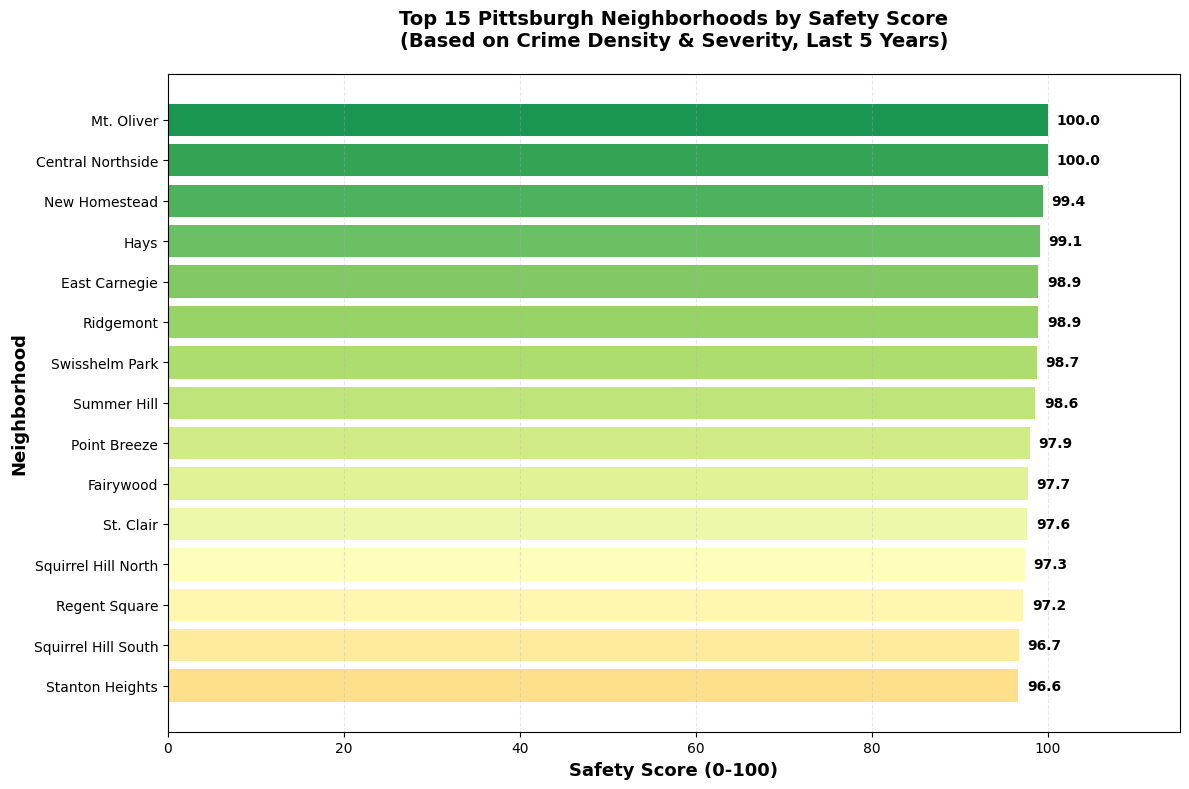

Saved: docs/safety_scatter.png


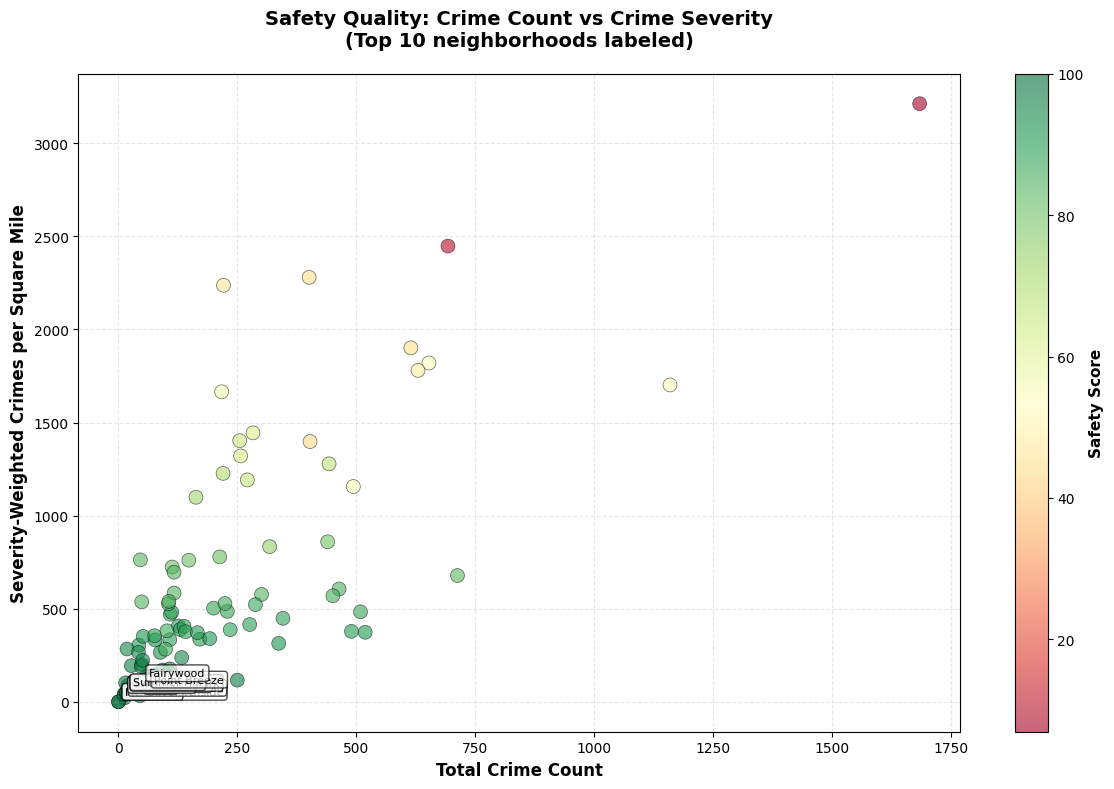

Saved: docs/crime_distribution_all.png


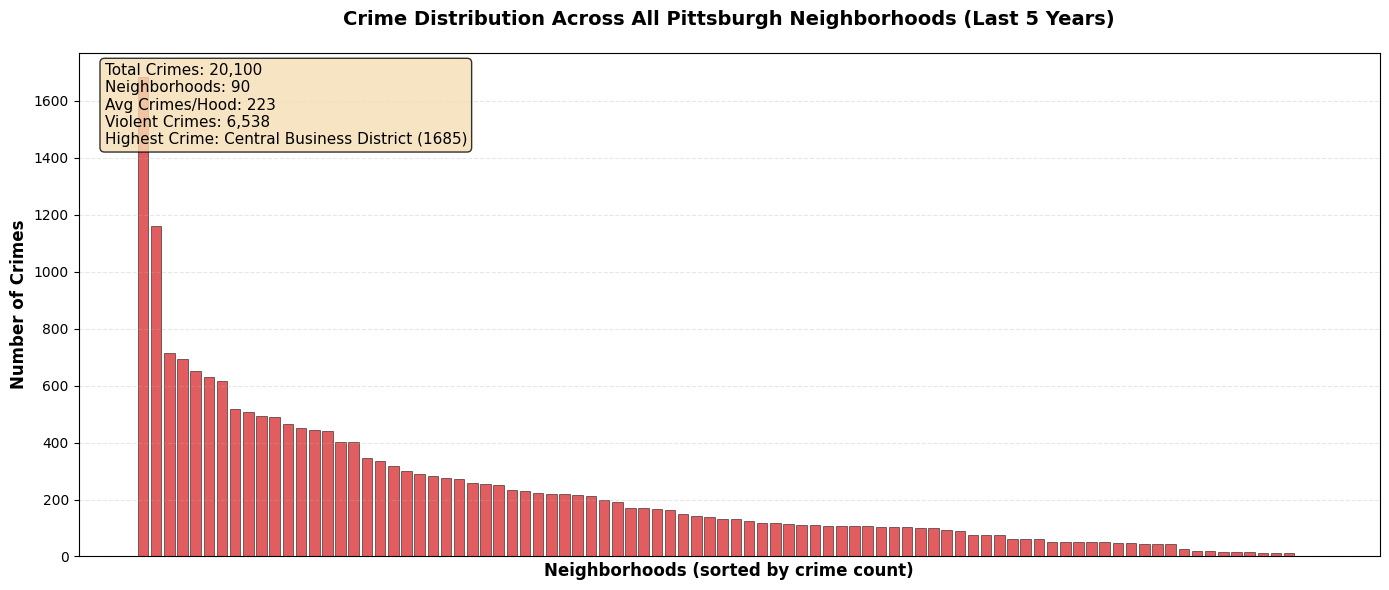

In [35]:
# visualize

# Ensure output directory exists to avoid FileNotFoundError when saving figures
import os
os.makedirs('docs', exist_ok=True)

# visual 1: horizontal bar chart of top 15 safest neighborhoods
fig, ax = plt.subplots(figsize=(12, 8))
top_15_sorted = merged.nlargest(15, 'safety_score').sort_values('safety_score')

colors = plt.cm.RdYlGn(np.linspace(0.4, 0.9, len(top_15_sorted)))
bars = ax.barh(top_15_sorted['hood'], top_15_sorted['safety_score'], color=colors)

for i, (bar, value) in enumerate(zip(bars, top_15_sorted['safety_score'])):
    ax.text(value + 1, i, f'{value:.1f}', 
            va='center', fontsize=10, fontweight='bold')

ax.set_xlabel('Safety Score (0-100)', fontsize=13, fontweight='bold')
ax.set_ylabel('Neighborhood', fontsize=13, fontweight='bold')
ax.set_title('Top 15 Pittsburgh Neighborhoods by Safety Score\n(Based on Crime Density & Severity, Last 5 Years)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlim(0, max(top_15_sorted['safety_score']) * 1.15)
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('docs/safety_rankings.png', dpi=300, bbox_inches='tight')
print("Saved: docs/safety_rankings.png")
plt.show()

# visual 2: crime count vs severity scatter
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(merged['total_crimes'], 
                     merged['severity_per_sq_mi'],
                     c=merged['safety_score'],
                     cmap='RdYlGn',
                     s=100,
                     alpha=0.6,
                     edgecolors='black',
                     linewidth=0.5)

top_10 = merged.nlargest(10, 'safety_score')
for _, row in top_10.iterrows():
    ax.annotate(row['hood'], 
                (row['total_crimes'], row['severity_per_sq_mi']),
                fontsize=8,
                xytext=(5, 5),
                textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

ax.set_xlabel('Total Crime Count', fontsize=12, fontweight='bold')
ax.set_ylabel('Severity-Weighted Crimes per Square Mile', fontsize=12, fontweight='bold')
ax.set_title('Safety Quality: Crime Count vs Crime Severity\n(Top 10 neighborhoods labeled)', 
             fontsize=14, fontweight='bold', pad=20)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Safety Score', fontsize=11, fontweight='bold')

ax.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('docs/safety_scatter.png', dpi=300, bbox_inches='tight')
print("Saved: docs/safety_scatter.png")
plt.show()

# visual 3: distribution of crimes across city
fig, ax = plt.subplots(figsize=(14, 6))

all_hoods = merged.sort_values('total_crimes', ascending=False)

ax.bar(range(len(all_hoods)), all_hoods['total_crimes'], 
       color='#d7191c', alpha=0.7, edgecolor='black', linewidth=0.5)

ax.set_xlabel('Neighborhoods (sorted by crime count)', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Crimes', fontsize=12, fontweight='bold')
ax.set_title('Crime Distribution Across All Pittsburgh Neighborhoods (Last 5 Years)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks([])  # remove x-axis labels (too many neighborhoods)

textstr = f"Total Crimes: {merged['total_crimes'].sum():,.0f}\n"
textstr += f"Neighborhoods: {len(merged)}\n"
textstr += f"Avg Crimes/Hood: {merged['total_crimes'].mean():.0f}\n"
textstr += f"Violent Crimes: {merged['violent_crimes'].sum():,.0f}\n"
textstr += f"Highest Crime: {all_hoods.iloc[0]['hood']} ({all_hoods.iloc[0]['total_crimes']:.0f})"

props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('docs/crime_distribution_all.png', dpi=300, bbox_inches='tight')
print("Saved: docs/crime_distribution_all.png")
plt.show()

## 1.6 Save results

In [36]:
output_df = merged[[
    'hood', 
    'total_crimes',
    'violent_crimes',
    'property_crimes',
    'minor_crimes',
    'sqmiles',
    'crimes_per_sq_mi',
    'severity_per_sq_mi',
    'safety_score'
]].sort_values('safety_score', ascending=False)

output_df.to_csv('data/safety_scores.csv', index=False)
print("Saved: safety_scores.csv")
print("\nFirst 10 rows of output:")
print(output_df.head(10))

Saved: safety_scores.csv

First 10 rows of output:
                 hood  total_crimes  violent_crimes  property_crimes  \
38  Central Northside           0.0             0.0              0.0   
67         Mt. Oliver           0.0             0.0              0.0   
37      New Homestead          13.0             5.0              1.0   
25               Hays          45.0            14.0              6.0   
28      East Carnegie          12.0             4.0              2.0   
64          Ridgemont          12.0             1.0              5.0   
82     Swisshelm Park          16.0             7.0              1.0   
76        Summer Hill          17.0             4.0              3.0   
59       Point Breeze          61.0            12.0             12.0   
23          Fairywood          50.0            25.0             10.0   

    minor_crimes   sqmiles  crimes_per_sq_mi  severity_per_sq_mi  safety_score  
38           0.0  0.259678          0.000000            0.000000        100